In [1]:
import datetime
print('Last updated:', datetime.datetime.now(), '(PT)')

Last updated: 2020-07-17 13:20:04.230523 (PT)


In [2]:
import pystan
import numpy as np
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('../../src/dp-gmm/util')
from pystan_vb_extract import pystan_vb_extract
import copy
from scipy.special import logsumexp

In [3]:
import pystan
from scipy.stats import multivariate_normal

In [683]:
# See: https://maggielieu.com/2017/03/21/multivariate-gaussian-mixture-model-done-properly/
# See: https://mc-stan.org/docs/2_19/stan-users-guide/gaussian-process-regression.html
warped_mixture = """
data {
    int D;               // number of dimensions
    int K;               // number of gaussians
    int N;               // number of data
    matrix[N,D] y;       // data
    vector[K] eta;       // dirichlet parameter
    int num_units;       // number of units in hidden layer of neural net
    real<lower=0> sigma;
    matrix[D, D] S;
    real<lower=0> s_mu;
    real<lower=0> nn_scale;
}
parameters {
    simplex[K] w;         // mixing proportions
    ordered[D] mu[K];     // mixture component means
    matrix[N,D] x;        // latent parameters
    
    // neural net parameters
    matrix[D, num_units] W1;
    row_vector[num_units] B1;
    matrix[num_units, D] W2;
    row_vector[D] B2;
}
transformed parameters {
    matrix[N, K] soft_c; // log unnormalized clusters
    matrix[N, D] z;
    
    for (n in 1:N) {
        for (k in 1:K) {
            soft_c[n, k] = log(w[k]) + multi_normal_lpdf(x[n, :] | mu[k], S);
        }
    }
    
    // nerual net predictions
    z =  tanh(x * W1 + rep_matrix(B1, N)) * W2 +  rep_matrix(B2, N);
}
model {
    w ~ dirichlet(eta);  // mixture weights
  
    // https://mc-stan.org/docs/2_18/stan-users-guide/multivariate-hierarchical-priors-section.html
    for (k in 1:K){
       mu[k] ~ normal(0, s_mu);  // prior mixture locations (D-dim for each k)
    }
    
    // neural net priors
    B1 ~ normal(0, nn_scale);
    B2 ~ normal(0, nn_scale);    
    for (d in 1:D) {
        W1[d, :] ~ normal(0, nn_scale);
        W2[:, d] ~ normal(0, nn_scale);
    }
     
    for (n in 1:N){
       // GMM
       target += log_sum_exp(soft_c[n, :]);
    }
    
    // likelihood
    for (d in 1:D) {
        y[:, d] ~ normal(z[:, d], sigma);
    }
}
"""

In [684]:
%%time
sm = pystan.StanModel(model_code=warped_mixture)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bdcd8fa17ae19f295b2f86b7e425cc1a NOW.


CPU times: user 1.15 s, sys: 40 ms, total: 1.19 s
Wall time: 56.3 s


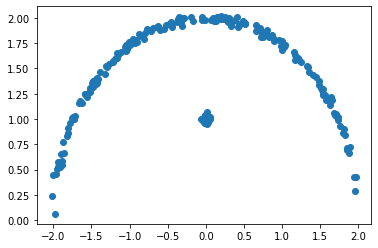

In [685]:
def gen_rainbow_data(N1=60, N2=30, r=2, s=0.1, sx=0.01, sy=0.01):
    x1 = np.random.rand(N1) * 2 * r - r
    y1 = np.sqrt(r*r - x1*x1)
    x2 = np.random.randn(N2) * sx
    y2 = np.random.randn(N2) * sy + 1
    x = np.concatenate([x1, x2])
    y = np.concatenate([y1, y2])
    z = np.stack([x, y], axis=1)
    return z + np.random.randn(N1 + N2, 2) * s

# Generate data
np.random.seed(1)
y = gen_rainbow_data(s=0.02, N1=200, N2=100)
plt.scatter(y[:, 0], y[:, 1]);

In [768]:
# Data dictionary
K = 10
N, D = y.shape
data = dict(y=y, D=D, N=N, K=K, eta=np.full(K, 1/K),
            num_units=16, S=np.eye(D) / 100, sigma=0.01, s_mu=10, nn_scale=1)
init = dict(x=np.random.randn(N, D) * 2, z=y)

## HMC

In [769]:
# %%time
# Sample from posterior via HMC
# hmc_fit = sm.sampling(data=data, iter=500, chains=1, warmup=500, thin=1, seed=1,
#                        algorithm="HMC", control=dict(stepsize=0.1, int_time=1))
# samples = hmc_fit

## ADVI

In [770]:
%%time
# Fit via ADVI
vb_fit = sm.vb(data=data, iter=10000, seed=1, init=init)
samples = pystan_vb_extract(vb_fit)

CPU times: user 1min 7s, sys: 211 ms, total: 1min 7s
Wall time: 1min 6s


## Plots

In [771]:
x = samples['x']
x_mean = x.mean(0)

z = samples['z']
zmean = z.mean(0)

mu = samples['mu']
mu_mean = mu.mean(0)

w = samples['w']
w_mean = w.mean(0)

soft_c = samples['soft_c']

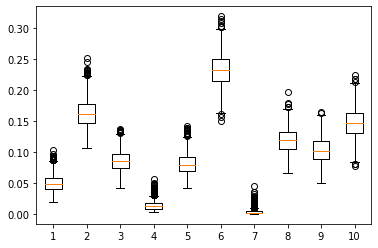

In [772]:
plt.boxplot(w);

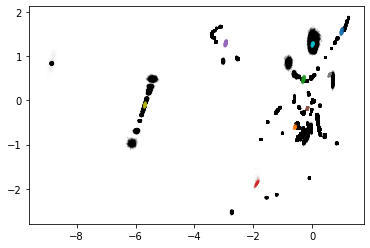

In [773]:
# FIXME: Something looks off here...
for xi in x:
    plt.scatter(xi[:, 0], xi[:, 1], c='black', s=1, alpha=0.1)

for k in range(data['K']):
    if w_mean[k] > 0:
        plt.scatter(mu[:, k, 0], mu[:, k, 1], alpha=w_mean[k], s=1);
        
# plt.xlim(-6, 6)
# plt.ylim(-6, 6)

In [774]:
def compute_probs(soft_c):
    unnormalized_probs = soft_c - logsumexp(soft_c, axis=-1, keepdims=True)
    return np.exp(unnormalized_probs)

In [775]:
probs = compute_probs(samples['soft_c'])
probs.mean(0).argmax(1)

array([4, 2, 5, 0, 8, 8, 5, 5, 5, 1, 5, 1, 5, 2, 0, 1, 4, 5, 8, 5, 2, 5,
       8, 1, 1, 1, 5, 8, 8, 5, 5, 5, 2, 3, 1, 8, 1, 2, 0, 5, 1, 2, 5, 4,
       8, 4, 1, 8, 8, 5, 5, 4, 5, 8, 3, 0, 5, 5, 5, 5, 8, 5, 1, 4, 0, 1,
       1, 7, 5, 2, 5, 8, 8, 2, 4, 8, 5, 5, 5, 5, 2, 2, 1, 5, 5, 5, 5, 2,
       1, 1, 5, 2, 5, 1, 7, 5, 2, 4, 8, 2, 5, 1, 5, 5, 2, 5, 5, 5, 1, 5,
       0, 5, 1, 5, 5, 5, 4, 5, 1, 5, 5, 6, 0, 8, 2, 1, 1, 2, 8, 8, 1, 5,
       1, 5, 1, 0, 2, 5, 1, 1, 1, 5, 0, 8, 0, 8, 0, 5, 1, 8, 5, 5, 2, 8,
       8, 5, 0, 5, 2, 2, 5, 4, 2, 2, 5, 5, 8, 5, 1, 1, 4, 5, 1, 5, 1, 1,
       3, 5, 0, 5, 1, 8, 5, 8, 8, 5, 8, 2, 4, 5, 8, 0, 2, 4, 1, 2, 8, 0,
       1, 5, 9, 7, 9, 9, 9, 9, 9, 9, 9, 1, 7, 7, 4, 9, 7, 1, 4, 9, 9, 1,
       4, 1, 9, 7, 7, 7, 7, 9, 4, 7, 4, 9, 7, 4, 7, 9, 9, 9, 9, 1, 3, 7,
       7, 7, 7, 1, 4, 1, 9, 7, 7, 9, 9, 9, 9, 7, 9, 9, 1, 9, 9, 1, 9, 7,
       7, 4, 7, 1, 9, 9, 9, 7, 9, 1, 7, 7, 7, 9, 9, 9, 7, 7, 1, 9, 9, 7,
       9, 7, 9, 7, 9, 9, 9, 9, 7, 7, 9, 9, 4, 4])

## $Y$ by cluster

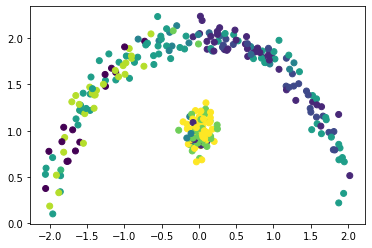

In [776]:
# labels = probs[0, :, :].argmax(-1)
labels = probs.mean(0).argmax(-1)
plt.scatter(y[:, 0] + np.random.randn(N) * .1,
            y[:, 1] + np.random.randn(N) * .1, c=labels);

## Z

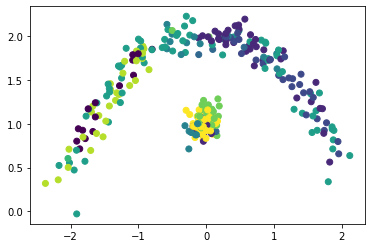

In [777]:
plt.scatter(zmean[:, 0] + np.random.randn(N) * .1,
            zmean[:, 1] + np.random.randn(N) * .1, c=labels);

## X

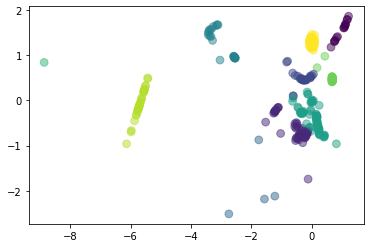

In [778]:
# for xi in x[:10]:
#     plt.scatter(xi[:, 0], xi[:, 1], c=labels, s=60, alpha=0.5) 
plt.scatter(x_mean[:, 0], x_mean[:, 1], c=labels, s=60, alpha=0.5);

# $\mu$ only

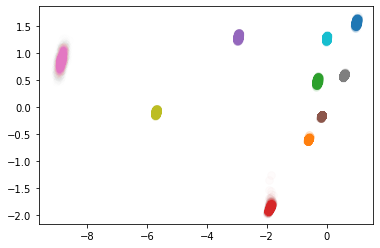

In [779]:
for k in range(data['K']):
    if w_mean[k] > 0:
        plt.scatter(mu[:, k, 0], mu[:, k, 1], alpha=w_mean[k], s=60);